# 文件分類

本次練習為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的三個版別文章做示範。

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具  

In [208]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from matplotlib import font_manager

設定中文字體 

In [209]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


Text(0.5, 1.0, '聲量圖')

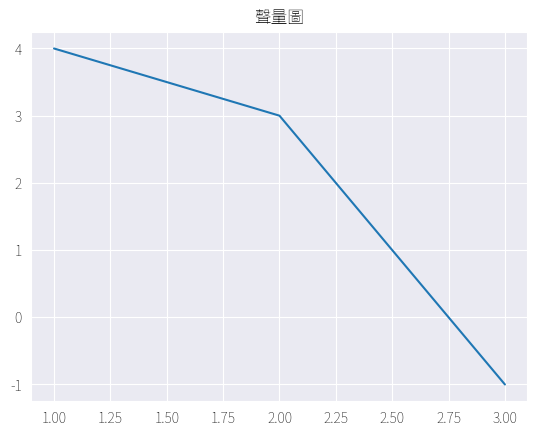

In [210]:
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

# 2. 文字前處理
`聯合新聞.csv`裡面包含了要分析的 udn 新聞資料。
- 版別：全球(global)、社會(social)、產經(produce)、股市(stock)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無
 

In [211]:
# 文字前處理
udn = pd.read_csv("data/聯合新聞.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,NaN,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站，在其他盟友對提供軍援猶豫不決時，展現對烏克蘭的支持。烏克蘭接待席科斯基（Radoslaw Sikorski）來訪時，表示希望迅速解決波蘭卡車司機封堵邊界的問題，並說波蘭外長這次訪問為兩國關係翻開「新頁」。在前任政府執政下，波蘭與烏克蘭關係緊張。俄羅斯過去幾週加強了空襲。席科斯基訪問時，烏克蘭空襲警報響起，警告可能有新的俄羅斯突擊行動。席科斯基在結束訪問的記者會上說：「如果西方動員起來，對於何方將勝出，我絲毫沒有懷疑，但最終還是必須開始動員。」他說，西方經濟體「比俄羅斯富裕20倍」，但莫斯科「已將其經濟切換成戰爭模式」。他說：「我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多。因為戰爭不是靠著戰術戰鬥贏的，戰爭是透過生產打贏的。」法新社報導，俄烏戰爭打了近兩年，儘管烏克蘭官員努力遊說，基輔盟國對這場衝突漸漸感到疲倦。在美國，聯邦參議院領袖19日表示，華府無法在年底前通過對烏克蘭的新援助。在歐洲，匈牙利擋下歐洲聯盟（EU）價值500億歐元的援烏方案，儘管歐盟與烏克蘭啟動正式入盟談判，讓烏克蘭取得象徵性勝利，但真正的入盟尚需數年時間。席科斯基這次訪問是為了讓基輔安心，而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的。俄烏戰爭於2022年2月開打時，歐盟取消烏克蘭貨運公司進入歐盟的限制，以緩解進出烏克蘭的貨運量。但波蘭卡車司機說，此舉導致他們的營收變少，因此一直封鎖波蘭與烏克蘭的邊界，而烏克蘭的進出口嚴重仰賴這條路線。烏克蘭外交部長庫列巴（Dmytro Kuleba）稍早提到這個問題時跟席科斯基說：「首先要做的是解除邊界封鎖，因為我們的友好關係籠罩在邊界遭圍堵的陰影下，這種情況令人無法接受且是有害的。」波蘭副基礎建設部長甘卡茲（Pawel Gancarz）稍後在基輔與席科斯基一同舉行的記者會上說：「我們希望這個問題能在耶誕節前、在今年年底前解決。」,UDN
1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,NaN,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，協助俄國規避制裁的金融機構也恐成制裁對象。華府正試圖加強對俄國施壓。綜合法新社和路透社報導，已有多家公司因支援俄羅斯國防工業而受制裁，如果金融機構支持這些公司，美方將根據這項行政命令對金融機構祭出所謂的「次級制裁」。白宮表示，這項行政命令也授權華府擴大對部分俄國商品的進口禁令，例如海產和鑽石。白宮國家安全顧問蘇利文（Jake Sullivan）在聲明中說：「我們正發出明確的訊息：任何支持俄羅斯非法戰爭活動者，恐怕都會被踢出美國金融體系。」蘇利文表示，新的制裁措施將「持續施壓俄羅斯戰爭機器及其推手」，還說先前的措施已「大大削弱」俄軍實力。俄羅斯軍隊長期以來被視為全球最強大的軍隊之一，近幾個月來仰賴北韓和伊朗進口。北韓和伊朗也都受到西方制裁。美國對烏克蘭軍事援助的資金即將耗盡，美國和盟邦正尋找新的方法來減緩俄羅斯戰力。哥倫比亞大學（Columbia University）制裁專家費希曼（Edward Fishman）說，華府早已有權制裁非俄羅斯金融機構，但今天的行政命令凸顯「外國金融機構面臨切實風險，其中許多機構似乎還沒有意識到這一點」。這波措施明確指出，金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易，包括部分關鍵物品的銷售，美方就可以鎖定這些金融機構。不具名的政府高層官員透露，這項命令是與盟邦協調發布。然而，自俄烏戰爭爆發以來，俄國一直加快腳步減少與西方接觸，避免以美元、歐元、英鎊和日圓進行貿易。與此同時，隨著西方機構退出，中國最大的數家銀行自俄烏戰爭開打以來，已向俄羅斯借出價值數十億美元的人民幣信貸。美國財政部副部長艾迪耶摩（Wally Adeyemo）表示，中國、土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁，新措施將針對規模較小的機構。艾迪耶摩接受財經媒體CNBC訪問時說，俄羅斯一直在設立幌子公司來隱藏透過第3國的採購，「他們不會透過這些國家的大公司，而是透過小公司取得微電子器件、機具和引擎零件等產品」，「但這些公司全都還是必須使用金融體系」。,UDN
2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,NaN,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前線擊落3架俄羅斯蘇愷34（Su-34）戰鬥轟炸機，並稱讚這是俄烏交戰22個月來的一大戰果。俄羅斯軍方並未提及這起事件，但俄國的部落客承認俄方確實有折損，分析家指出，烏軍可能用了美國供應的愛國者飛彈，但路透社無法獨立證實前述這些消息。烏克蘭空軍司令歐勒什丘克（Mykola Oleshchuk）於通訊應用程式Telegram寫道：「今天中午在南部戰區，掉了3架俄羅斯蘇愷34戰鬥轟炸機！」空軍發言人伊納特（Yuri Ihnat）告訴烏克蘭國營電視台，這是一場「精心策劃的行動」。他說道，「在我們確實的統計數據中，已經有一段時間沒有出現蘇愷34」，更形容蘇愷34是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一。澤倫斯基在晚間談話影片中，讚揚敖德薩地區（Odesa）防空部隊擊落赫松地區（Kherson）上空的這些蘇愷34。俄軍2022年2月全面入侵烏克蘭的頭幾天，就占領了赫松地區大片領土，此後烏軍試圖收復失土，今年11月在赫松地區的第聶伯河（Dnipro River）東岸建立陣地。總部位於俄羅斯的「歐亞日報」（Eurasia Daily）稱烏克蘭說法是可信的，基輔當局可能從第聶伯河西岸，發射針對高空目標、射程可達160公里的愛國者飛彈。烏克蘭航空專家羅曼能柯（Valeriy Romanenko）向烏國當地廣播電台表示，他認為愛國者飛彈擊落俄軍戰機的可能性很高，還說俄軍沒有充分考量到愛國者飛彈的射程達到160公里。,UDN


In [212]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8803
date range: ('2023-12-23 00:04:00', '2024-01-13 23:54:00')
category: 
artCatagory
產經    2760
全球    2570
社會    1817
股市    1655
生活       1
Name: count, dtype: int64


In [213]:
# 去除artCatagory是生活
udn = udn[udn['artCatagory'] != '生活']

# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8802
date range: ('2023-12-23 00:04:00', '2024-01-13 23:54:00')
category: 
artCatagory
產經    2760
全球    2570
社會    1817
股市    1655
Name: count, dtype: int64


＃我們將聯合時報的產經版面與股市版面資料匯總，對應到自由時報的財經版面

In [214]:
udn.loc[udn['artCatagory'].isin(['產經', '股市']), 'artCatagory'] = '財經'

# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8802
date range: ('2023-12-23 00:04:00', '2024-01-13 23:54:00')
category: 
artCatagory
財經    4415
全球    2570
社會    1817
Name: count, dtype: int64


In [215]:
udn.to_csv('data/聯合新聞_merge.csv')

+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字） 

### 2.1 清理 

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。 

In [163]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,波蘭新外長籲西方挺烏基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,NaN,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站在其他盟友對提供軍援猶豫不決時展現對烏克蘭的支持烏克蘭接待席科斯基來訪時表示希望迅速解決波蘭卡車司機封堵邊界的問題並說波蘭外長這次訪問為兩國關係翻開新頁在前任政府執政下波蘭與烏克蘭關係緊張俄羅斯過去幾週加強了空襲席科斯基訪問時烏克蘭空襲警報響起警告可能有新的俄羅斯突擊行動席科斯基在結束訪問的記者會上說如果西方動員起來對於何方將勝出我絲毫沒有懷疑但最終還是必須開始動員他說西方經濟體比俄羅斯富裕倍但莫斯科已將其經濟切換成戰爭模式他說我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多因為戰爭不是靠著戰術戰鬥贏的戰爭是透過生產打贏的法新社報導俄烏戰爭打了近兩年儘管烏克蘭官員努力遊說基輔盟國對這場衝突漸漸感到疲倦在美國聯邦參議院領袖日表示華府無法在年底前通過對烏克蘭的新援助在歐洲匈牙利擋下歐洲聯盟價值億歐元的援烏方案儘管歐盟與烏克蘭啟動正式入盟談判讓烏克蘭取得象徵性勝利但真正的入盟尚需數年時間席科斯基這次訪問是為了讓基輔安心而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的俄烏戰爭於年月開打時歐盟取消烏克蘭貨運公司進入歐盟的限制以緩解進出烏克蘭的貨運量但波蘭卡車司機說此舉導致他們的營收變少因此一直封鎖波蘭與烏克蘭的邊界而烏克蘭的進出口嚴重仰賴這條路線烏克蘭外交部長庫列巴稍早提到這個問題時跟席科斯基說首先要做的是解除邊界封鎖因為我們的友好關係籠罩在邊界遭圍堵的陰影下這種情況令人無法接受且是有害的波蘭副基礎建設部長甘卡茲稍後在基輔與席科斯基一同舉行的記者會上說我們希望這個問題能在耶誕節前在今年年底前解決,UDN
1,2,美國加強施壓俄羅斯拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,NaN,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄國規避制裁的金融機構也恐成制裁對象華府正試圖加強對俄國施壓綜合法新社和路透社報導已有多家公司因支援俄羅斯國防工業而受制裁如果金融機構支持這些公司美方將根據這項行政命令對金融機構祭出所謂的次級制裁白宮表示這項行政命令也授權華府擴大對部分俄國商品的進口禁令例如海產和鑽石白宮國家安全顧問蘇利文在聲明中說我們正發出明確的訊息任何支持俄羅斯非法戰爭活動者恐怕都會被踢出美國金融體系蘇利文表示新的制裁措施將持續施壓俄羅斯戰爭機器及其推手還說先前的措施已大大削弱俄軍實力俄羅斯軍隊長期以來被視為全球最強大的軍隊之一近幾個月來仰賴北韓和伊朗進口北韓和伊朗也都受到西方制裁美國對烏克蘭軍事援助的資金即將耗盡美國和盟邦正尋找新的方法來減緩俄羅斯戰力哥倫比亞大學制裁專家費希曼說華府早已有權制裁非俄羅斯金融機構但今天的行政命令凸顯外國金融機構面臨切實風險其中許多機構似乎還沒有意識到這一點這波措施明確指出金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易包括部分關鍵物品的銷售美方就可以鎖定這些金融機構不具名的政府高層官員透露這項命令是與盟邦協調發布然而自俄烏戰爭爆發以來俄國一直加快腳步減少與西方接觸避免以美元歐元英鎊和日圓進行貿易與此同時隨著西方機構退出中國最大的數家銀行自俄烏戰爭開打以來已向俄羅斯借出價值數十億美元的人民幣信貸美國財政部副部長艾迪耶摩表示中國土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁新措施將針對規模較小的機構艾迪耶摩接受財經媒體訪問時說俄羅斯一直在設立幌子公司來隱藏透過第國的採購他們不會透過這些國家的大公司而是透過小公司取得微電子器件機具和引擎零件等產品但這些公司全都還是必須使用金融體系,UDN
2,3,俄烏交戰來一大戰果烏克蘭稱擊落俄軍架蘇愷專家愛國者飛彈建功,2023-12-23 17:49:00,全球,NaN,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交戰個月來的一大戰果俄羅斯軍方並未提及這起事件但俄國的部落客承認俄方確實有折損分析家指出烏軍可能用了美國供應的愛國者飛彈但路透社無法獨立證實前述這些消息烏克蘭空軍司令歐勒什丘克於通訊應用程式寫道今天中午在南部戰區掉了架俄羅斯蘇愷戰鬥轟炸機空軍發言人伊納特告訴烏克蘭國營電視台這是一場精心策劃的行動他說道在我們確實的統計數據中已經有一段時間沒有出現蘇愷更形容蘇愷是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一澤倫斯基在晚間談話影片中讚揚敖德薩地區防空部隊擊落赫松地區上空的這些蘇愷俄軍年月全面入侵烏克蘭的頭幾天就占領了赫松地區大片領土此後烏軍試圖收復失土今年月在赫松地區的第聶伯河東岸建立陣地總部位於俄羅斯的歐亞日報稱烏克蘭說法是可信的基輔當局可能從第聶伯河西岸發射針對高空目標射程可達公里的愛國者飛彈烏克蘭航空專家羅曼能柯向烏國當地廣播電台表示他認為愛國者飛彈擊落俄軍戰機的可能性很高還說俄軍沒有充分考量到愛國者飛彈的射程達到公里,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。 

In [164]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,波蘭新外長籲西方挺烏基輔盼迅速解除邊界封鎖波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站在其他盟友對提供軍援猶豫不決時展現對烏克蘭的支持烏克蘭接待席科斯基來訪時表示希望迅速解決波蘭卡車司機封堵邊界的問題並說波蘭外長這次訪問為兩國關係翻開新頁在前任政府執政下波蘭與烏克蘭關係緊張俄羅斯過去幾週加強了空襲席科斯基訪問時烏克蘭空襲警報響起警告可能有新的俄羅斯突擊行動席科斯基在結束訪問的記者會上說如果西方動員起來對於何方將勝出我絲毫沒有懷疑但最終還是必須開始動員他說西方經濟體比俄羅斯富裕倍但莫斯科已將其經濟切換成戰爭模式他說我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多因為戰爭不是靠著戰術戰鬥贏的戰爭是透過生產打贏的法新社報導俄烏戰爭打了近兩年儘管烏克蘭官員努力遊說基輔盟國對這場衝突漸漸感到疲倦在美國聯邦參議院領袖日表示華府無法在年底前通過對烏克蘭的新援助在歐洲匈牙利擋下歐洲聯盟價值億歐元的援烏方案儘管歐盟與烏克蘭啟動正式入盟談判讓烏克蘭取得象徵性勝利但真正的入盟尚需數年時間席科斯基這次訪問是為了讓基輔安心而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的俄烏戰爭於年月開打時歐盟取消烏克蘭貨運公司進入歐盟的限制以緩解進出烏克蘭的貨運量但波蘭卡車司機說此舉導致他們的營收變少因此一直封鎖波蘭與烏克蘭的邊界而烏克蘭的進出口嚴重仰賴這條路線烏克蘭外交部長庫列巴稍早提到這個問題時跟席科斯基說首先要做的是解除邊界封鎖因為我們的友好關係籠罩在邊界遭圍堵的陰影下這種情況令人無法接受且是有害的波蘭副基礎建設部長甘卡茲稍後在基輔與席科斯基一同舉行的記者會上說我們希望這個問題能在耶誕節前在今年年底前解決,https://udn.com/news/story/122663/7660679,全球
1,美國加強施壓俄羅斯拜登簽署行政命令鎖定金融機構美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄國規避制裁的金融機構也恐成制裁對象華府正試圖加強對俄國施壓綜合法新社和路透社報導已有多家公司因支援俄羅斯國防工業而受制裁如果金融機構支持這些公司美方將根據這項行政命令對金融機構祭出所謂的次級制裁白宮表示這項行政命令也授權華府擴大對部分俄國商品的進口禁令例如海產和鑽石白宮國家安全顧問蘇利文在聲明中說我們正發出明確的訊息任何支持俄羅斯非法戰爭活動者恐怕都會被踢出美國金融體系蘇利文表示新的制裁措施將持續施壓俄羅斯戰爭機器及其推手還說先前的措施已大大削弱俄軍實力俄羅斯軍隊長期以來被視為全球最強大的軍隊之一近幾個月來仰賴北韓和伊朗進口北韓和伊朗也都受到西方制裁美國對烏克蘭軍事援助的資金即將耗盡美國和盟邦正尋找新的方法來減緩俄羅斯戰力哥倫比亞大學制裁專家費希曼說華府早已有權制裁非俄羅斯金融機構但今天的行政命令凸顯外國金融機構面臨切實風險其中許多機構似乎還沒有意識到這一點這波措施明確指出金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易包括部分關鍵物品的銷售美方就可以鎖定這些金融機構不具名的政府高層官員透露這項命令是與盟邦協調發布然而自俄烏戰爭爆發以來俄國一直加快腳步減少與西方接觸避免以美元歐元英鎊和日圓進行貿易與此同時隨著西方機構退出中國最大的數家銀行自俄烏戰爭開打以來已向俄羅斯借出價值數十億美元的人民幣信貸美國財政部副部長艾迪耶摩表示中國土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁新措施將針對規模較小的機構艾迪耶摩接受財經媒體訪問時說俄羅斯一直在設立幌子公司來隱藏透過第國的採購他們不會透過這些國家的大公司而是透過小公司取得微電子器件機具和引擎零件等產品但這些公司全都還是必須使用金融體系,https://udn.com/news/story/122663/7661029,全球
2,俄烏交戰來一大戰果烏克蘭稱擊落俄軍架蘇愷專家愛國者飛彈建功烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交戰個月來的一大戰果俄羅斯軍方並未提及這起事件但俄國的部落客承認俄方確實有折損分析家指出烏軍可能用了美國供應的愛國者飛彈但路透社無法獨立證實前述這些消息烏克蘭空軍司令歐勒什丘克於通訊應用程式寫道今天中午在南部戰區掉了架俄羅斯蘇愷戰鬥轟炸機空軍發言人伊納特告訴烏克蘭國營電視台這是一場精心策劃的行動他說道在我們確實的統計數據中已經有一段時間沒有出現蘇愷更形容蘇愷是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一澤倫斯基在晚間談話影片中讚揚敖德薩地區防空部隊擊落赫松地區上空的這些蘇愷俄軍年月全面入侵烏克蘭的頭幾天就占領了赫松地區大片領土此後烏軍試圖收復失土今年月在赫松地區的第聶伯河東岸建立陣地總部位於俄羅斯的歐亞日報稱烏克蘭說法是可信的基輔當局可能從第聶伯河西岸發射針對高空目標射程可達公里的愛國者飛彈烏克蘭航空專家羅曼能柯向烏國當地廣播電台表示他認為愛國者飛彈擊落俄軍戰機的可能性很高還說俄軍沒有充分考量到愛國者飛彈的射程達到公里,https://udn.com/news/story/122663/7661229,全球
3,烏克蘭再傳軍購弊案國防高官涉盜千萬美元恐面臨年刑期紐約時報報導當地時間日烏克蘭一名高級國防官員涉嫌中飽私囊盜用軍購案近萬美元目前已遭撤職逮捕查證屬實恐面臨最高年有期徒刑烏克蘭檢方在聲明中表示年月該官員與一家製造商簽署購買砲彈後來國防部新成立的採購部與同家廠商改簽新約不僅成本降低且省去通過外國中介商而大幅縮短交貨期可是該官員仍延長舊約且把將近萬美元轉給外國中介商當局並未公布涉貪官員姓名並表示該批彈藥尚未交付正在努力追回這筆錢今年月烏克蘭國防部長因捲入貪汙遭撤職此後烏克蘭當局一直努力整頓內部烏克蘭總統澤倫斯基也將打擊貪腐作為戰時主要目標之一不僅是為了向西方盟國保證數十億美元金援沒有遭挪用同時保障彈藥短缺的情況下有效分配資源近日烏軍才表示出於砲彈匱乏而縮減軍事行動規模這並非烏克蘭在戰爭期間發生的首起軍購舞弊去年兩名國防官員以過高價格購買雞蛋遭法辦,https://udn.com/news/story/122663/7661805,全球
4,紐時普亭透過秘密外交管道釋出和談訊息願就目前戰線停火紐約時報報導俄羅斯總統普亭日前在公開場合堅定表示俄烏戰爭打到底不過就知情的俄國前官員及美國官員透露至少從月以來克里姆林宮已透過外交秘密管道釋出和談訊息且不排除就目前戰線停火只要能讓俄國宣稱獲勝即可事實上美國官員表示早在一年前也就是年秋天烏軍在俄國東北部將俄軍打得落花流水當時普亭便釋出有意停火的訊息表示已經滿意目前奪得的領土且準備停戰只不過沒有獲得報導知情官員表示普亭的停火協議包括烏克蘭維持主權並繼續以基輔作為首都俄國則保留占領的烏克蘭領土至於烏克蘭加入北約是否會阻撓協議一名前俄國官員表示就可見未來而言烏克蘭不太可能入北約因此不大可能成為破局因素不過美國高階官員則說烏克蘭一直以來以收復全部領土為主張沒有證據說明其領導人會接受停戰協議普亭反覆表現出有意停火的姿態說明投機主義和隨機應變成為他關起門來處理戰爭的方式熟知普亭且深諳克里姆林宮內部運作的採訪對象及國際官員在數十次訪問中表示俄烏戰爭打得比普亭預期還久期間他一直設法降低風險並保持開放的選擇不過部分美國官員也表示這有可能是克里姆林宮一貫得誤導伎倆並非普亭真的有意妥協俄國前官員也補充倘若俄軍勢頭強勁普亭很可能再次改變主意其中一名俄國前高級官員向紐時表示他確實有意就目前戰線停火他不願意後退一點即使是一公尺現任及前任官員不約而同提到陷入僵局的戰況烏克蘭遲遲無法推進的攻勢普亭在西方日益下滑的支持度加之月爆發的以巴衝突等等目前種種條件讓普亭認為是停戰的時機克里姆林宮發言人培斯科夫回覆評論表示原則上這些說法是不正確的問及俄國是否準備就目前戰線停火培斯科夫援引普亭近來發言稱俄國的目標沒有改變普亭確實準備也說過打算談俄國一直準備好了在滿足俄國自身目標的前提下,https://udn.com/news/story/122663/7662087,全球


In [165]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")

total docs: 2873


### 2.2 斷詞 

In [166]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [167]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [168]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from C:\Users\eddie\GitHub\StockNatrakLanguageAnalyze\dict\dict.txt.big ...
Loading model from cache C:\Users\eddie\AppData\Local\Temp\jieba.ua398e1f90d463cf314deaaa432abb2fc.cache
Loading model cost 1.749 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,波蘭新外長籲西方挺烏基輔盼迅速解除邊界封鎖波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一站在其他盟友對提供軍援猶豫不決時展現對烏克蘭的支持烏克蘭接待席科斯基來訪時表示希望迅速解決波蘭卡車司機封堵邊界的問題並說波蘭外長這次訪問為兩國關係翻開新頁在前任政府執政下波蘭與烏克蘭關係緊張俄羅斯過去幾週加強了空襲席科斯基訪問時烏克蘭空襲警報響起警告可能有新的俄羅斯突擊行動席科斯基在結束訪問的記者會上說如果西方動員起來對於何方將勝出我絲毫沒有懷疑但最終還是必須開始動員他說西方經濟體比俄羅斯富裕倍但莫斯科已將其經濟切換成戰爭模式他說我們不能讓俄羅斯在經濟規模小得多的基礎上生產更多因為戰爭不是靠著戰術戰鬥贏的戰爭是透過生產打贏的法新社報導俄烏戰爭打了近兩年儘管烏克蘭官員努力遊說基輔盟國對這場衝突漸漸感到疲倦在美國聯邦參議院領袖日表示華府無法在年底前通過對烏克蘭的新援助在歐洲匈牙利擋下歐洲聯盟價值億歐元的援烏方案儘管歐盟與烏克蘭啟動正式入盟談判讓烏克蘭取得象徵性勝利但真正的入盟尚需數年時間席科斯基這次訪問是為了讓基輔安心而解決波蘭貨運公司對烏克蘭邊界長達一個月的封鎖是此行首要目的俄烏戰爭於年月開打時歐盟取消烏克蘭貨運公司進入歐盟的限制以緩解進出烏克蘭的貨運量但波蘭卡車司機說此舉導致他們的營收變少因此一直封鎖波蘭與烏克蘭的邊界而烏克蘭的進出口嚴重仰賴這條路線烏克蘭外交部長庫列巴稍早提到這個問題時跟席科斯基說首先要做的是解除邊界封鎖因為我們的友好關係籠罩在邊界遭圍堵的陰影下這種情況令人無法接受且是有害的波蘭副基礎建設部長甘卡茲稍後在基輔與席科斯基一同舉行的記者會上說我們希望這個問題能在耶誕節前在今年年底前解決,https://udn.com/news/story/122663/7660679,全球,波蘭 外長 西方 基輔 迅速 解除 邊界 封鎖 波蘭 新任 外交部長 科斯 今天 敦促 西方 團結 力挺 烏克蘭 選擇 飽受 戰爭 蹂躪 國家 外訪 第一站 盟友 提供 軍援 猶豫不決 展現 烏克蘭 支持 烏克蘭 接待 科斯 來訪 表示 希望 迅速 解決 波蘭 卡車司機 封堵 邊界 問題 並說 波蘭 外長 這次 訪問 兩國關係 翻開 新頁 前任 政府 執政 波蘭 烏克蘭 關係 緊張 俄羅斯 過去 幾週 加強 空襲 科斯 訪問 烏克蘭 空襲警報 響起 警告 俄羅斯 突擊 行動 科斯 基在 結束 訪問 記者會 西方 動員 何方 勝出 絲毫 懷疑 最終 動員 西方 經濟體 俄羅斯 富裕 莫斯科 已將 經濟 切換 戰爭 模式 俄羅斯 經濟 規模 小得多 基礎 生產 更多 戰爭 戰術 戰鬥 贏的 戰爭 透過 生產 打贏 法新社 俄烏 戰爭 近兩年 烏克蘭 官員 努力 遊說 基輔 盟國 這場 衝突 漸漸 感到疲倦 美國聯邦 參議院 領袖 表示 華府 無法 年底 烏克蘭 援助 歐洲 匈牙利 歐洲聯盟 價值 歐元 烏方 歐盟 烏克蘭 啟動 正式 入盟 談判 烏克蘭 取得 象徵性 勝利 真正 入盟 尚需 數年 時間 科斯 這次 訪問 基輔 安心 解決 波蘭 貨運公司 烏克蘭 邊界 長達 一個月 封鎖 此行 首要 目的 俄烏 戰爭 開打 歐盟 取消 烏克蘭 貨運公司 進入 歐盟 限制 緩解 進出 烏克蘭 貨運量 波蘭 卡車司機 此舉 導致 營收 變少 一直 封鎖 波蘭 烏克蘭 邊界 烏克蘭 進出口 嚴重 仰賴 這條 路線 烏克蘭 外交部長 列巴 稍早 提到 問題 時跟席 科斯 基說 解除 邊界 封鎖 友好關係 籠罩 邊界 圍堵 陰影 情況 令人 無法 接受 有害 波蘭 基礎 建設 部長 甘卡茲 稍後 基輔 與席 科斯 一同 舉行 記者會 希望 問題 耶誕節 今年年底 解決
1,美國加強施壓俄羅斯拜登簽署行政命令鎖定金融機構美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄國規避制裁的金融機構也恐成制裁對象華府正試圖加強對俄國施壓綜合法新社和路透社報導已有多家公司因支援俄羅斯國防工業而受制裁如果金融機構支持這些公司美方將根據這項行政命令對金融機構祭出所謂的次級制裁白宮表示這項行政命令也授權華府擴大對部分俄國商品的進口禁令例如海產和鑽石白宮國家安全顧問蘇利文在聲明中說我們正發出明確的訊息任何支持俄羅斯非法戰爭活動者恐怕都會被踢出美國金融體系蘇利文表示新的制裁措施將持續施壓俄羅斯戰爭機器及其推手還說先前的措施已大大削弱俄軍實力俄羅斯軍隊長期以來被視為全球最強大的軍隊之一近幾個月來仰賴北韓和伊朗進口北韓和伊朗也都受到西方制裁美國對烏克蘭軍事援助的資金即將耗盡美國和盟邦正尋找新的方法來減緩俄羅斯戰力哥倫比亞大學制裁專家費希曼說華府早已有權制裁非俄羅斯金融機構但今天的行政命令凸顯外國金融機構面臨切實風險其中許多機構似乎還沒有意識到這一點這波措施明確指出金融機構若代表受到美國制裁的企業或與俄國軍事工業基礎相關的公司從事交易包括部分關鍵物品的銷售美方就可以鎖定這些金融機構不具名的政府高層官員透露這項命令是與盟邦協調發布然而自俄烏戰爭爆發以來俄國一直加快腳步減少與西方接觸避免以美元歐元英鎊和日圓進行貿易與此同時隨著西方機構退出中國最大的數家銀行自俄烏戰爭開打以來已向俄羅斯借出價值數十億美元的人民幣信貸美國財政部副部長艾迪耶摩表示中國土耳其和阿拉伯聯合大公國等國的主要銀行已很努力避免抵觸美方制裁新措施將針對規模較小的機構艾迪耶摩接受財經媒體訪問時說俄羅斯一直在設立幌子公司來隱藏透過第國的採購他們不會透過這些國家的大公司而是透過小公司取得微電子器件機具和引擎零件等產品但這些公司全都還是必須使用金融體系,https://udn.com/news/story/122663/7661029,全球,美國 加強 施壓 俄羅斯 拜登 簽署 行政命令 鎖定 金融機構 美國白宮 聲明 表示 總統 拜登 今天 簽署 行政命令 將對 支持 俄羅斯 攻打 烏克蘭 外國 銀行 制裁 協助 俄國 規避 制裁 金融機構 恐成 制裁 對象 華府 正試圖 加強 俄國 施壓 綜合 法新社 路透社 已有 多家 公司 支援 俄羅斯 國防工業 制裁 金融機構 支持 公司 美方 這項 行政命令 金融機構 所謂 次級 制裁 白宮 表示 這項 行政命令 授權 華府 擴大 部分 俄國 商品 進口 禁令 海產 鑽石 白宮 國家 安全 顧問 蘇利文 聲明 中說 發出 明確 訊息 支持 俄羅斯 非法 戰爭 活動 踢出 美國 金融體系 蘇利文 表示 制裁 措施 持續 施壓 俄羅斯 戰爭 機器 推手 還說 先前 措施 削弱 俄軍 實力 俄羅斯 軍隊 被視 全球 強大 軍隊 近幾個月 仰賴 北韓 伊朗 進口 北韓 伊朗 受到 西方 制裁 美國 烏克蘭 軍事援助 資金 耗盡 美國 盟邦 尋找 方法 減緩 俄羅斯 戰力 哥倫比亞大學 制裁 專家 希曼 華府 早已 有權 制裁 俄羅斯 金融機構 今天 行政命令 凸顯 外國 金融機構 面臨 切實 風險 許多 機構 似乎 意識 一點 這波 措施 明確指出 金融機構 代表 受到 美國 制裁 企業 俄國 軍事 工業 基礎 相關 公司 從事 交易 包括 部分 關鍵 物品 銷售 美方 鎖定 金融機構 具名 政府 高層 官員 透露 這項 命令 盟邦 協調 發布 自俄烏 戰爭 爆發 以來 俄國 一直 加快腳步 減少 西方 接觸 避免 美元 歐元 英鎊 日圓 進行 貿易 西方 機構 退出 中國 最大 數家 銀行 自俄烏 戰爭 開打 以來 俄羅斯 借出 價值 數十億美元 人民幣 信貸 美國財政部 副部長 艾迪 耶摩 表示 中國 土耳其 阿拉伯 聯合 大公國 等國 主要 銀行 努力 避免 抵觸 美方 制裁 措施 針對 規模較 機構 艾迪 耶摩 接受 財經 媒體 訪問 時說 俄羅斯 一直 設立 幌子 公司 隱藏 透過 第國 採購 透過 國家 公司 透過 公司 取得 電子器件 機具 引擎 零件 產品 公司 使用 金融體系
2,俄烏交戰來一大戰果烏克蘭稱擊落俄軍架蘇愷專家愛國者飛彈建功烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交戰個月來的一大戰果俄羅斯軍方並未提及這起事件但俄國的部落客承認俄方確實有折損分析家指出烏軍可能用了美國供應的愛國者飛彈但路透社無法獨立證實前述這些消息烏克蘭空軍司令歐勒什丘克於通訊應用程式寫道今天中午在南部戰區掉了架俄羅斯蘇愷戰鬥轟炸機空軍發言人伊納特告訴烏克蘭國營電視台這是一場精心策劃的行動他說道在我們確實的統計數據中已經有一段時間沒有出現蘇愷更形容蘇愷是可用於轟炸和其他攻擊行動的俄國最現代化戰機之一澤倫斯基在晚間談話影片中讚揚敖德薩地區防空部隊擊落赫松地區上空的這些蘇愷俄軍年月全面入侵烏克蘭的頭幾天就占領了赫松地區大片領土此後烏軍試圖收復失土今年月在赫松地區的第聶伯河東岸建立陣地總部位於俄羅斯的歐亞日報稱烏克蘭說法是可信的基輔當局可能從第聶伯河西岸發射針對高空目標射程可達公里的愛國者飛彈烏克蘭航空專家羅曼能柯向烏國當地廣播電台表示他認為愛國者飛彈擊落俄軍戰機的可能性很高還說俄軍沒有充分考量到愛國者飛彈的射程達到公里,https://udn.com/news/story/122663/7661229,全球,俄烏 交戰 一大 戰果 烏克蘭 擊落 俄軍 蘇愷 專家 愛國者 飛彈 建功 烏克蘭 總統 倫斯基 軍方 官員 表示 今天 南部 前線 擊落 俄羅斯 蘇愷 戰鬥 轟炸機 稱讚 這是 交戰 一大 戰果 俄羅斯 軍方 並未 提及 這起 

### 2.3 資料集基本檢視 

檢視資料內容

In [169]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

total posts: 2873
category: 
artCatagory
財經    1377
全球     775
社會     721
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。 

In [170]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

4958    英業達 國一生 醫界 多家 富國 神山 全盼 法規 鬆綁 代工 大廠 英業達 創辦人 葉國 今日 指出 國內 生醫 產業 建立 多家 富國 神山 技術 開發 受限 主管機關 審查 效率 過慢 導致 生技 發展 步伐 停滯不前 他稱 延遲 一兩個 禮拜 電子業 生技 醫療 業有 很大 影響 喊話 政府 儘速 調整 政策 法規 鬆綁 惟有 產業 發展 充滿 彈性 真正 世界 競爭 英業達 創辦人 葉國 今日 出席 國家 創新獎 頒獎典禮 攜手 友達 宣布 加入 新創 投資 聯盟 透露 投資 電子業 是從 製造 電晶體 做起 當時 投資 環境 受到 嚴格 管制 形式 投資 警備總部 同意 進展 常會 遇到 萬事俱備 審核 過程 卡關 情況 葉國 分享 每半年 檢查 一次 牙齒 每次 習慣 找同 一位 熟識 張姓 牙醫 時隔 半年 回診 發現 這位 牙醫 身形 消瘦 詢問 得知 原來 胰臟 生命 剩個 昨天 參加 這位 老友 告別式 瞬間 有感而發 再次 體悟 預防 重要性 英業達 友達 正式 新創 投資 聯盟 締約 合作 葉國 指出 過去 進行 一次 醫療 檢驗 須要 耗費 大量 時間 金錢 透過 三方 合作 人工智慧 技術 科技 創新 實際 生技 醫療 進行 結合 將能 大幅 加速 醫療 檢測 效率 肝癌 胰臟 發作 前提 篩檢 治療 技術 普及 也將 創造 商機 葉國 表示 發現 市場 許多 新創 團隊 投資 型態 參與 明確 財報 上市 公司 股東 負責 財報 一定 清清楚楚 目前 透過 名義 投資 幫忙 推動 發展 希望 未來 企業 加入 提供 新創 團隊 協助 葉國 透露 國內 生醫 產業 已有 多家 富國 神山 面臨 挑戰 此時 政府 絕不能 口號 應該 積極 的將 部分 法令 進行 適度 鬆綁 法規 某種 鬆綁 富國 神山 很大 幫助 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 新聞 追蹤 科技 玩家 好文 漏接 限免 貼圖 款來 毛孩 動圖 聖誕節 新年 跨年 祝賀 必用 二手 蘋果 注意 達人 曝點 檢查 項目 避免 奇妙 發光 四格 窗戶 桌布 特效 拍攝 方法 曝光 竟是 實景 手機 充飽電 不到 小時 電量 直墜 內行人 曝全 這別 周報 取消 仍多 

In [171]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
財經    47.928994
全球    26.975287
社會    25.095719
Name: proportion, dtype: float64

train percentage :
artCatagory
財經    48.483342
全球    27.001492
社會    24.515167
Name: proportion, dtype: float64

test percentage :
artCatagory
財經    46.635731
全球    26.914153
社會    26.450116
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer 

In [172]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [173]:
X_train.head()

4958    英業達 國一生 醫界 多家 富國 神山 全盼 法規 鬆綁 代工 大廠 英業達 創辦人 葉國 今日 指出 國內 生醫 產業 建立 多家 富國 神山 技術 開發 受限 主管機關 審查 效率 過慢 導致 生技 發展 步伐 停滯不前 他稱 延遲 一兩個 禮拜 電子業 生技 醫療 業有 很大 影響 喊話 政府 儘速 調整 政策 法規 鬆綁 惟有 產業 發展 充滿 彈性 真正 世界 競爭 英業達 創辦人 葉國 今日 出席 國家 創新獎 頒獎典禮 攜手 友達 宣布 加入 新創 投資 聯盟 透露 投資 電子業 是從 製造 電晶體 做起 當時 投資 環境 受到 嚴格 管制 形式 投資 警備總部 同意 進展 常會 遇到 萬事俱備 審核 過程 卡關 情況 葉國 分享 每半年 檢查 一次 牙齒 每次 習慣 找同 一位 熟識 張姓 牙醫 時隔 半年 回診 發現 這位 牙醫 身形 消瘦 詢問 得知 原來 胰臟 生命 剩個 昨天 參加 這位 老友 告別式 瞬間 有感而發 再次 體悟 預防 重要性 英業達 友達 正式 新創 投資 聯盟 締約 合作 葉國 指出 過去 進行 一次 醫療 檢驗 須要 耗費 大量 時間 金錢 透過 三方 合作 人工智慧 技術 科技 創新 實際 生技 醫療 進行 結合 將能 大幅 加速 醫療 檢測 效率 肝癌 胰臟 發作 前提 篩檢 治療 技術 普及 也將 創造 商機 葉國 表示 發現 市場 許多 新創 團隊 投資 型態 參與 明確 財報 上市 公司 股東 負責 財報 一定 清清楚楚 目前 透過 名義 投資 幫忙 推動 發展 希望 未來 企業 加入 提供 新創 團隊 協助 葉國 透露 國內 生醫 產業 已有 多家 富國 神山 面臨 挑戰 此時 政府 絕不能 口號 應該 積極 的將 部分 法令 進行 適度 鬆綁 法規 某種 鬆綁 富國 神山 很大 幫助 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 英業達 創辦人 葉國 記者 吳康瑋 攝影 新聞 追蹤 科技 玩家 好文 漏接 限免 貼圖 款來 毛孩 動圖 聖誕節 新年 跨年 祝賀 必用 二手 蘋果 注意 達人 曝點 檢查 項目 避免 奇妙 發光 四格 窗戶 桌布 特效 拍攝 方法 曝光 竟是 實景 手機 充飽電 不到 小時 電量 直墜 內行人 曝全 這別 周報 取消 仍多 

In [174]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<2011x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 152088 stored elements in Compressed Sparse Row format>

In [175]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [176]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一些' '一半' '一句' '一名' '一定' '一家' '一年' '一度' '一次' '一直']


In [177]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'代工': 69, '大廠': 292, '今日': 67, '指出': 442, '國內': 253, '產業': 655, '建立': 387, '技術': 431, '開發': 945, '審查': 330, '導致': 341, '發展': 670, '醫療': 926, '影響': 397, '政府': 484, '調整': 832, '政策': 486, '世界': 32, '出席': 151, '國家': 254, '攜手': 471, '宣布': 320, '加入': 171, '新創': 495, '投資': 435, '透露': 884, '製造': 807, '當時': 665, '環境': 649, '受到': 206, '同意': 225, '過程': 910, '情況': 406, '分享': 154, '檢查': 571, '一次': 8, '發現': 672, '詢問': 828, '昨天': 518, '再次': 148, '正式': 578, '合作': 221, '過去': 909, '進行': 905, '大量': 297, '時間': 520, '透過': 883, '人工智慧': 61, '科技': 704, '創新': 168, '大幅': 291, '加速': 176, '治療': 599, '也將': 46, '創造': 169, '商機': 238, '表示': 802, '市場': 361, '許多': 825, '團隊': 260, '參與': 202, '上市': 20, '公司': 139, '股東': 765, '一定': 4, '目前': 678, '推動': 456, '希望': 364, '未來': 545, '企業': 77, '提供': 458, '協助': 190, '面臨': 969, '挑戰': 446, '應該': 410, '積極': 707, '部分': 922, '幫助': 368, '記者': 821, '攝影': 472, '新聞': 502, '追蹤': 879, '玩家': 643, '好文': 303, '漏接': 621, '限免': 952, '貼圖': 846, '款來': 573, '毛孩': 589, '動圖': 178, '聖誕節': 757, '新年': 

0

In [178]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(2011, 1000)
(862, 1000)


In [179]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [180]:
clf.classes_

array(['全球', '社會', '財經'], dtype=object)

In [181]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['財經' '財經' '財經' '全球' '全球' '財經' '全球' '社會' '全球' '財經']


In [182]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(862, 3)


array([8.87795011e-09, 2.38991710e-10, 9.99999991e-01])

In [183]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.94      0.95      0.94       232
          社會       0.98      0.97      0.97       228
          財經       0.98      0.98      0.98       402

    accuracy                           0.97       862
   macro avg       0.96      0.97      0.96       862
weighted avg       0.97      0.97      0.97       862



In [184]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[220,   5,   7],
       [  6, 221,   1],
       [  9,   0, 393]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '全球'), Text(0, 1.5, '社會'), Text(0, 2.5, '財經')])

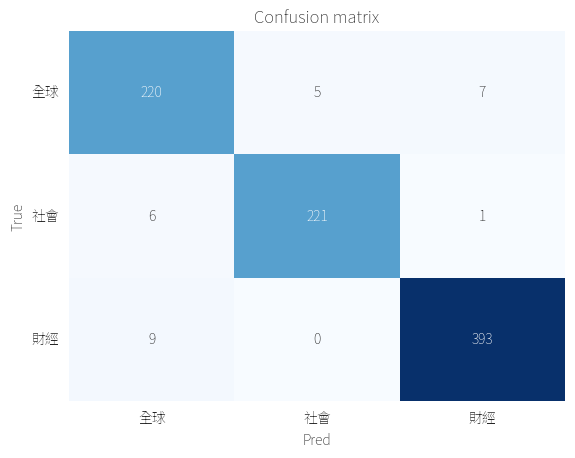

In [185]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [186]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.05162936,
       0.        , 0.        , 0.        , 0.09885165, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0561859 , 0.        , 0.        ,
       0.04975648, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04508522,
       0.        , 0.        , 0.05644981, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05605573, 0.        , 0.        , 0.        ,
       0.        , 0.05241231, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0495902 , 0.        , 0.        , 0.        ,
       0.        , 0.02677613, 0.12012004, 0.05542202, 0.06228163,
       0.        , 0.        , 0.        , 0.        , 0.     

In [187]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.95      0.92      0.94       232
          社會       0.97      0.97      0.97       228
          財經       0.97      0.99      0.98       402

    accuracy                           0.97       862
   macro avg       0.96      0.96      0.96       862
weighted avg       0.97      0.97      0.97       862



In [188]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[214,   8,  10],
       [  5, 222,   1],
       [  6,   0, 396]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '全球'), Text(0, 1.5, '社會'), Text(0, 2.5, '財經')])

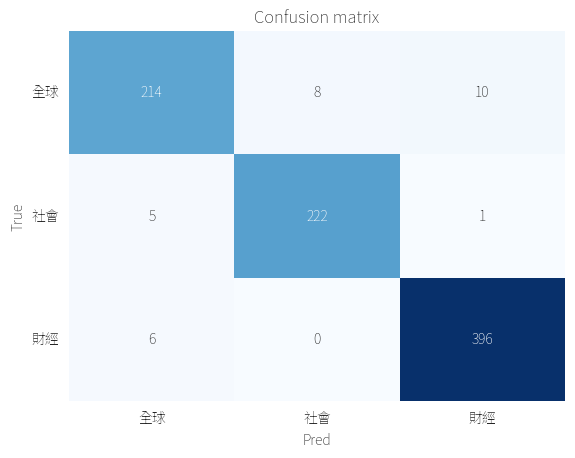

In [189]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

效果一樣也是不錯，可能因為三個新聞版別本來就有很大的差異，用字遣詞會不同。 

### 3.5 CV  

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。 

* figure1:  

![](images/grid_search_workflow.png) 

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [190]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.03399563, 0.03000188, 0.02999997, 0.03100109, 0.03099513]),
 'score_time': array([0.0070045 , 0.00599909, 0.0069952 , 0.00700426, 0.00700021]),
 'test_f1_macro': array([0.97504477, 0.96597168, 0.97184731, 0.96295525, 0.95837677]),
 'test_precision_macro': array([0.97586282, 0.96574407, 0.97085853, 0.97206176, 0.9635227 ]),
 'test_recall_macro': array([0.97424777, 0.96631909, 0.97346507, 0.95650954, 0.95395839])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [191]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          全球       0.97      0.93      0.95       543
          社會       0.97      0.98      0.97       493
          財經       0.97      0.99      0.98       975

    accuracy                           0.97      2011
   macro avg       0.97      0.96      0.97      2011
weighted avg       0.97      0.97      0.97      2011



## 4. 比較不同模型效果

In [192]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          全球       0.97      0.93      0.95       543
          社會       0.97      0.98      0.97       493
          財經       0.97      0.99      0.98       975

    accuracy                           0.97      2011
   macro avg       0.97      0.96      0.97      2011
weighted avg       0.97      0.97      0.97      2011



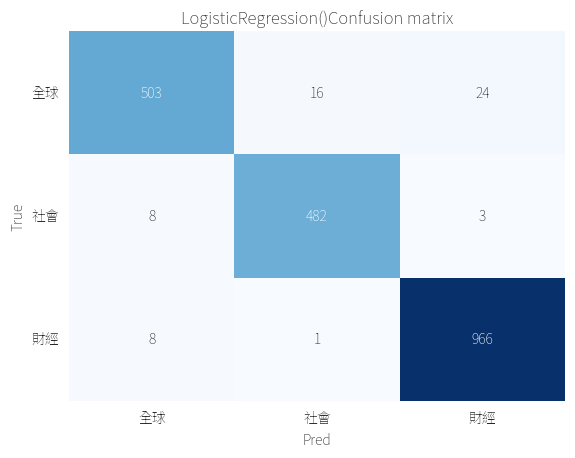

In [193]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          全球       0.97      0.93      0.95       543
          社會       0.97      0.98      0.97       493
          財經       0.97      0.99      0.98       975

    accuracy                           0.97      2011
   macro avg       0.97      0.96      0.97      2011
weighted avg       0.97      0.97      0.97      2011

now training: clf_dtree
              precision    recall  f1-score   support

          全球       0.79      0.80      0.80       543
          社會       0.86      0.86      0.86       493
          財經       0.91      0.91      0.91       975

    accuracy                           0.87      2011
   macro avg       0.85      0.85      0.85      2011
weighted avg       0.87      0.87      0.87      2011

now training: clf_svm
              precision    recall  f1-score   support

          全球       0.96      0.94      0.95       543
          社會       0.97      0.97      0.97       493
  

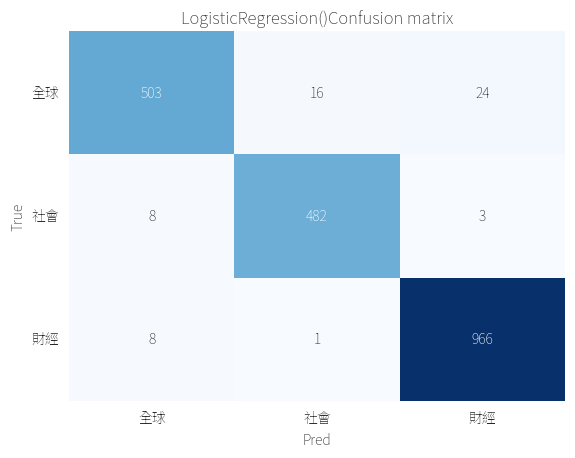

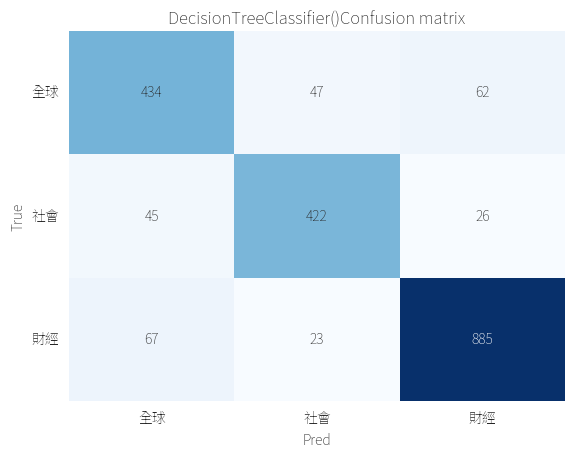

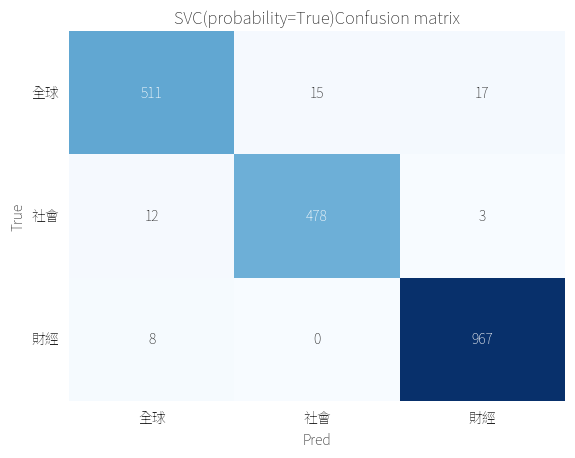

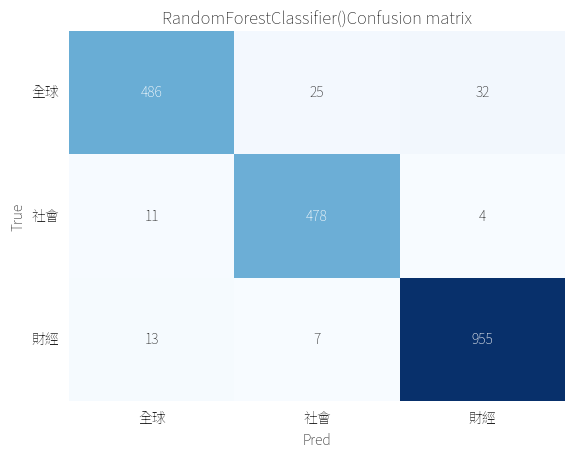

In [194]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [195]:
result_set['clf_logistic']

{'全球': {'precision': 0.9691714836223507,
  'recall': 0.9263351749539595,
  'f1-score': 0.9472693032015066,
  'support': 543.0},
 '社會': {'precision': 0.9659318637274549,
  'recall': 0.9776876267748479,
  'f1-score': 0.9717741935483871,
  'support': 493.0},
 '財經': {'precision': 0.972809667673716,
  'recall': 0.9907692307692307,
  'f1-score': 0.9817073170731707,
  'support': 975.0},
 'accuracy': 0.9701640974639483,
 'macro avg': {'precision': 0.9693043383411739,
  'recall': 0.9649306774993459,
  'f1-score': 0.9669169379410215,
  'support': 2011.0},
 'weighted avg': {'precision': 0.9701411986108626,
  'recall': 0.9701640974639483,
  'f1-score': 0.9699734178041345,
  'support': 2011.0}}

In [196]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.9726504226752859,
 'macro avg': {'f1-score': 0.9689619174697701,
               'precision': 0.970548609521639,
               'recall': 0.9674790160897319,
               'support': 2011.0},
 'weighted avg': {'f1-score': 0.972548545061173,
                  'precision': 0.9725465856256067,
                  'recall': 0.9726504226752859,
                  'support': 2011.0},
 '全球': {'f1-score': 0.9515828677839852,
        'precision': 0.9623352165725048,
        'recall': 0.9410681399631676,
        'support': 543.0},
 '社會': {'f1-score': 0.9695740365111561,
        'precision': 0.9695740365111561,
        'recall': 0.9695740365111561,
        'support': 493.0},
 '財經': {'f1-score': 0.9857288481141692,
        'precision': 0.9797365754812564,
        'recall': 0.9917948717948718,
        'support': 975.0}}


In [197]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.96      0.96      0.96       232
          社會       0.97      0.98      0.98       228
          財經       0.99      0.99      0.99       402

    accuracy                           0.98       862
   macro avg       0.97      0.97      0.97       862
weighted avg       0.98      0.98      0.98       862



In [198]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['全球'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [199]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

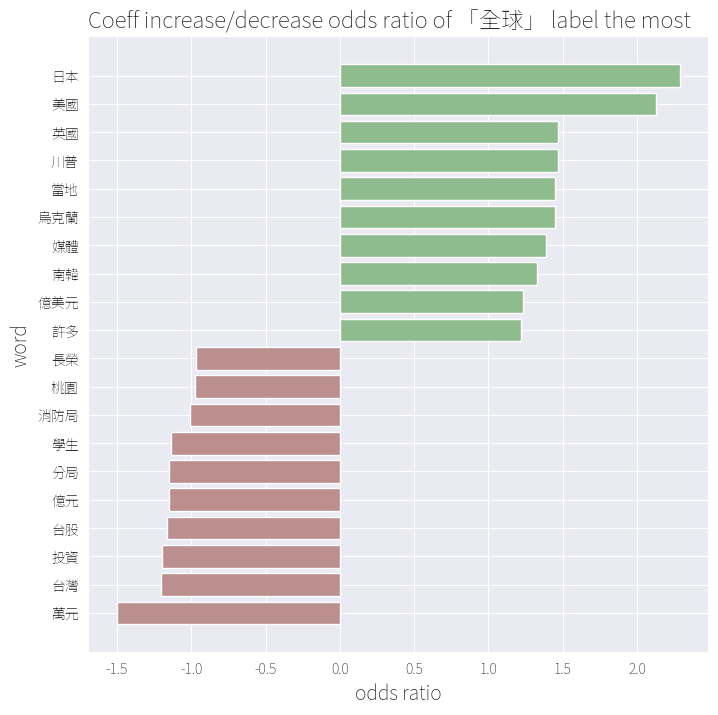

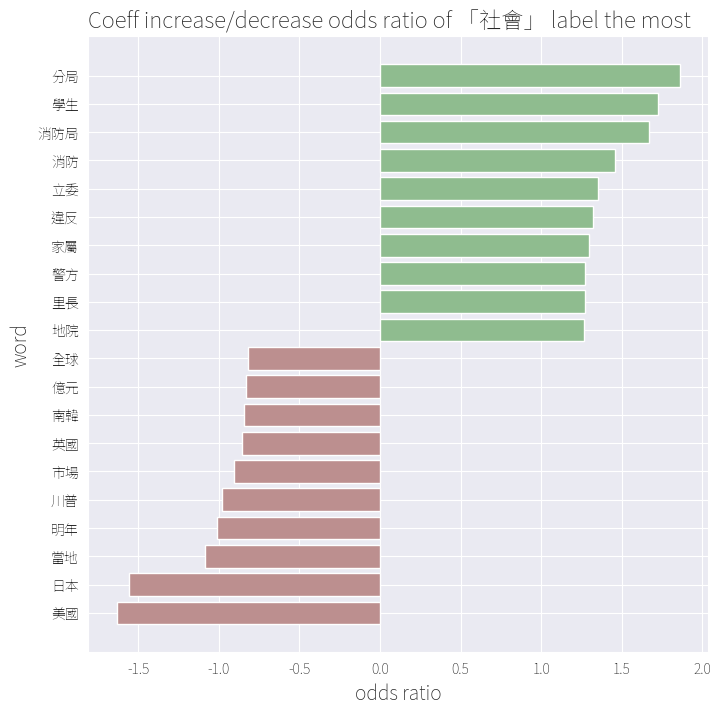

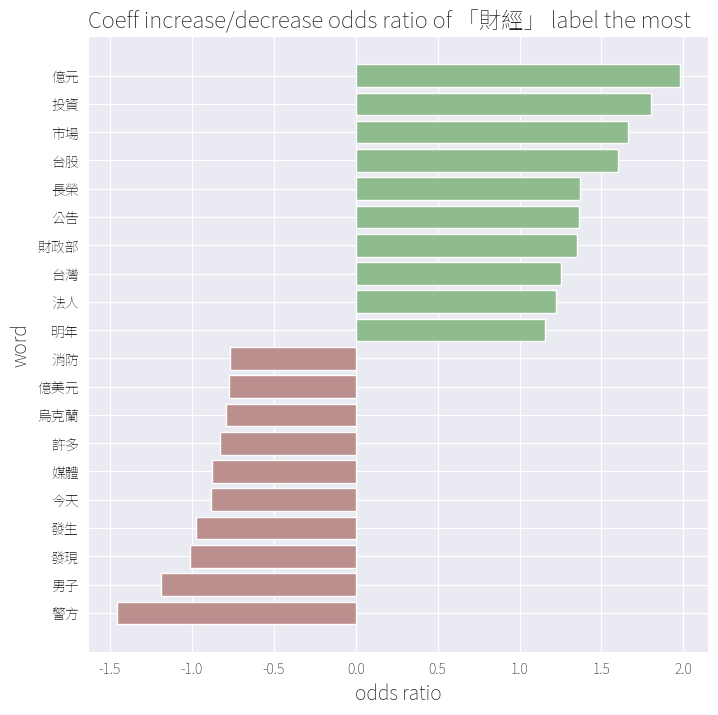

In [200]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

- 「全球」中出現了日本、美國、英國還有當地等國際新聞關鍵字，除了國家名稱外，也提到許多元首名稱，比較特殊的是，"當地"這個詞語也被廣泛使用。
- 「社會」中高係數的字是分局、學生、消防局與消防；「消防」可能與去年選舉前後時有明揚大火導致多名消防人員殉職有關;在許多社會新聞案件中，常提到是由哪些分局處理案件，因此「分局」也是社會新聞常見字彙，而「學生」則是可能與當時的國中生割頸案有關
- 「財經」則是億元、投資、市場與台股等相關詞彙，只會出現在財經相關新聞上。

## 6. 預測新聞類別

`自由時報.csv` 為自由時報網資料
- 版別：國際(world)、社會(society)、政治(politics)、財經(ec)
- 時間範圍：2023/12/23 ~ 2024/01/13
- 工作流程平台搜尋/排除關鍵字：無

In [201]:
ct = pd.read_csv("data/自由時報.csv")
ct.dropna(inplace=True)
ct

,system_id,dataSource,artUrl,artDate,artTitle,artContent,sub_media
0,1,ltn,https://ec.ltn.com.tw/article/paper/1623579,2023-12-30 21:30:00,習專制強推共富 人才錢財「潤」出國,中國房地產市場低迷，經濟復甦未如預期。圖為北京市東城區一處街邊相連著的3家店面都空置未使用。（中央社資料照）編譯盧永山／特譯中國成長前景黯淡，美中關係持續緊繃，在此背景下，中國國家主席習近平不僅縮緊對政經社會的控制，又推動「共同富裕」政策，導致中國經濟慘兮兮，越來越多中國的人才與富人帶著大量資金「潤」（run）出國。「我不想生活在恐懼之下」36歲百度AI專家出走英國曾在百度與阿里巴巴的人工智慧（AI）部門工作，現年三十六歲的陳亮時（音譯）表示：「我離開中國是因為我不喜歡那裡的社會和政治環境，我不會再回去，除非中國變成一個民主國家、除非中國人民不再生活在恐懼之下。」由於中國全國人大在二○一八年通過修憲，取消國家主席任期制，讓習近平可以無限期留任掌權，陳亮時被迫在二○二○年初做出離開中國的決定，現在他在Meta（臉書母公司）的倫敦分公司任職。紐時：今年前10月中國15.5兆資金外流除了人才流失，資金也源源不斷撤離中國。儘管要從中國合法把資金轉移到海外受到嚴格的限制，但根據《紐約時報》報導，二○二三年每月有五百億美元資金透過各種方式流出中國，主要來自中國富有家庭與民營企業，這意味二○二三年前十個月，中國可能有高達五千億美元（十五．五兆台幣）的資金外流。新加坡成為中國外流富人和資金的主要落腳處。新加坡之所以能吸引中國富人與資金，主要因為距離很近、低稅率和大量說華語的人口。根據新加坡金管局統計，在中國富人推動下，新加坡家族辦公室的數量從二○二○年的四百家，增至二○二二年底的一一○○家，二○二三年仍持續增加。國際房地產顧問公司「居外IQI」表示，預計未來二年將有超過七十萬名中國富人離開中國；包括澳洲、加拿大、英國、日本、甚至杜拜，都是中國富人熱門的移民置產地點。 \r\n 一手掌握經濟脈動,ec
1,2,ltn,https://ec.ltn.com.tw/article/breakingnews/4535539,2023-12-29 04:42:30,日經 : 台灣投資轉向 中國佔比降至幾十年來最低,台積電德國廠在今年8月宣布落腳德勒斯登，台積電對於德國廠將規劃34億美元的投資額。（路透）\r\n高佳菁／核稿編輯\r\n〔財經頻道／綜合報導〕以往中國是台商大舉投資的地方，隨著中國經濟疲軟和地緣政治緊張，國際品牌廠陸續撤出中國，台商也跟隨供應鏈腳步轉出。《日經亞洲》報導，2023年，台灣對中國的投資驟降至台灣對外直接投資總額的10%多一點，這是幾十年來的最低比例，而美國、德國的投資則快速增長。\r\n根據台灣官方數據顯示，台灣今年前11月批准的外國直接投資年增87%、達到257億美元（約新台幣7888億元），而對中國的投資下降了34%、至29億美元（約新台幣890億元），僅佔總數的12% 。\r\n日媒報導，台灣在中國的支出，自2010年的84%高峰開始下滑，來到2022年則大幅下降、佔投資總額34%，而今年的投資總額，預計將不到1999年以來最低點28%的一半。\r\n台灣大幅減少對中國投資，將投資重心移轉至美國與德國。累計今年前11月，台灣對美國直接投資成長了9倍、達到96億美元（約新台幣2948億元）、佔總投資的37%。台灣對美國的投資，預計約為中國的3倍，這是自1993年開始，台灣允許對中國直接投資以來，美國首次位居榜首。\r\n在德國投資部分，因台積電（2330）在德國設立新的晶片工廠帶動，德國投資成長了25倍、達到39億美元（約新台幣1197億元）。光是對德國的投資，也一舉超越投資中國的數字。\r\n台灣經濟研究院孫明德表示，只要中美關係持續緊張，台灣對中國投資將會持續下降。\r\n\r\n 一手掌握經濟脈動,ec
2,3,ltn,https://ec.ltn.com.tw/article/breakingnews/4509660,2023-12-31 23:37:24,LTN經濟通》AI始料未及？宮鬥劇峰回路轉,OpenAI執行長奧特曼在11月17日遭董事會解僱，隨後在短短5天後回歸，OpenAI內部宮鬥，引起全球關注。（美聯社資料照）\r\n奧特曼從開除到回歸 只花5天\r\n歐祥義／核稿編輯\r\n〔財經頻道／綜合報導〕OpenAI執行長奧特曼（Sam Altman）在11月17日遭董事會解僱，掀起軒然大波，大批員工威脅要離職，投資人也考慮提告董事會，讓OpenAI態度急轉彎，在開除奧特曼不到1天後，重新商議讓奧特曼回鍋，在「宮鬥」爆發5天後，OpenAI宣佈，奧特曼將回歸重新擔任執行長，結束這場鬧劇。\r\n事實上根據外媒透露，在被要求下台之前，奧特曼和公司董事會的爭執已持續1年多，隨著OpenAI推出的聊天機器人ChatGPT受到全球矚目，雙方的緊張局勢持續惡化。奧特曼一度採取行動，希望趕走一名董事會成員，因為他認為，這名董事會成員與他人一同撰寫的研究論文實質是在批評公司。\r\n但針對無預警開除奧特曼，並對解雇的原因OpenAI一直含糊其辭，董事會在一篇部落格文章中提到，奧特曼下台是因為他在與董事會的溝通中「始終不坦承」。一名知情人士表示，董事會成員對奧特曼愈來愈不信任，以至於他們認為有必要對奧特曼告知的所有事情進行反覆查核。另外也有董事會成員認為，奧特曼過度專注於擴張，而董事會則希望能在成長與AI安全之間取得平衡。\r\n根據3名參與視訊會議的人士透露，奧特曼被趕下台後，OpenAI高層在視訊通話中與其他董事會成員對峙。高層團隊向董事會表明，不好好說明，這一切結果將很難被接受，知情人士表示，在大約40分鐘的視訊會議中，高層持續向董事會施壓，要求提供奧特曼不夠坦誠的具體例子，都被董事會以法律因素回絕了。\r\nOpenAI執行長奧特曼（右）曾傳出與合作夥伴特斯拉執行長馬斯克（左）多次意見不合，最終導致馬斯克出走。（法新社、美聯社資料照，本報合成）\r\nOpenAI董事會一直不合\r\nOpenAI董事會問題並不是第一天的事，最早可以追溯到這家新創剛成立時。2015年奧特曼和特斯拉執行長馬斯克（Elon Musk）一同成立一個非營利組織來打造人工智慧，他們原計劃從私人捐款者那裡募集資金，但在短短幾年內，他們就意識到這項計劃所需的資金，遠遠超過獨立募款可以籌得的資金。\r\n由於高層之間意見嚴重不合，奧特曼和馬斯克之間關係出現裂痕，這也導致馬斯克在2018年離開這家公司。幾年後，OpenAI內部再度出現不合，在安全問題上發生衝突後，一群關鍵的研究人員離開，成立對手企業Anthropic。\r\n馬斯克離開後，他們成立了一家營利的子公司，並開始從投資人身上籌得數十億美元，其中也包括科技巨頭微軟（Microsoft）注資的10億美元（約新台幣315億元）。該公司在官網上表示，子公司由非營利董事會控制，每名董事要負責任的對象是「人類」，而不是OpenAI的投資人。\r\n首席科學家蘇茨克維是投票通過將奧特曼開除的董事會成員之一，引起風波後，蘇茨克維的態度也急轉彎，加入員工連署支持奧特曼回鍋。（法新社資料照）\r\n董事會成員 對AI發展認知相左\r\n據報，奧特曼被趕下台背後的因素，包括他與董事成員、喬治城安全與新興技術中心策略總監托納（Helen Toner）的衝突。在被解僱的幾週前，奧特曼會見了托納，雙方討論了托納為喬治城安全與新興技術中心撰寫的一篇論文。\r\n奧特曼抱怨，這篇研究論文似乎批評了OpenAI為了維持AI技術做出的努力，同時讚揚了競爭對手Anthropic。奧特曼認為，在聯邦貿易委員會（FTC）正在進行調查的期間，發表這篇論文恐對公司帶來不利影響。\r\n托納則稱，這是一篇學術論文，只是分析大眾在試圖了解國家、企業發展AI時面臨的挑戰。奧特曼卻不這麼認為，並稱，雙方對於這一切造成的損失並沒有達成共識，董事會成員的任何批評都會產生很大的影響。\r\n奧特曼和首席科學家蘇茨克維（Ilya Sutskever）在內的高層討論了是否該將托納從董事會中除名。但由於蘇茨克維對AI的擔憂，最終他和另外2名董事安捷羅（Adam D'Angelo）、麥考莉（Tasha McCauley）選擇與托納站在同一陣線，4人決定開除奧特曼。\r\nOpenAI董事會因針對人工智慧的安全隱憂出現分歧，引爆了這次的「宮鬥」。（法新社資料照，本報合成）\r\n微軟出手 擺平爭議\r\n今年OpenAI共3名董事離任，空缺也加劇了董事會問題。2名知情人士表示，董事會在董事成員接班問題上出現了分歧，在審查4名候選人後，董事未能決定要由誰遞補，這種僵局加劇了執行長奧特曼、總裁布羅克曼（Greg Brockman）和其他董事會成員之間的摩擦。\r\n奧特曼被開除後，布羅克曼也被告知自己將被從董事會除名，布羅克曼隨後也辭職以示抗議。OpenAI最大投資人微軟（Microsoft）隨後也向2人遞出橄欖枝，微軟執行長納德拉（Satya Nadella）在11月19日表示，歡迎奧特曼、布羅克曼帶上相關團隊成員加入微軟，領導高階AI研究團隊。\r\n董事會的行動也引發旗下員工不滿，表明對董事會失去信任，OpenAI員工發起聯署，要求恢復奧特曼的職位，否則將面臨旗下員工大規模離職。根據1名參與連署的人士表示，OpenAI約770名員工，已經有至少743人在幾個小時內簽署了

In [204]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,sub_media,words
0,習專制強推共富 人才錢財「潤」出國中國房地產市場低迷，經濟復甦未如預期。圖為北京市東城區一處街邊相連著的3家店面都空置未使用。（中央社資料照）編譯盧永山／特譯中國成長前景黯淡，美中關係持續緊繃，在此背景下，中國國家主席習近平不僅縮緊對政經社會的控制，又推動「共同富裕」政策，導致中國經濟慘兮兮，越來越多中國的人才與富人帶著大量資金「潤」（run）出國。「我不想生活在恐懼之下」36歲百度AI專家出走英國曾在百度與阿里巴巴的人工智慧（AI）部門工作，現年三十六歲的陳亮時（音譯）表示：「我離開中國是因為我不喜歡那裡的社會和政治環境，我不會再回去，除非中國變成一個民主國家、除非中國人民不再生活在恐懼之下。」由於中國全國人大在二○一八年通過修憲，取消國家主席任期制，讓習近平可以無限期留任掌權，陳亮時被迫在二○二○年初做出離開中國的決定，現在他在Meta（臉書母公司）的倫敦分公司任職。紐時：今年前10月中國15.5兆資金外流除了人才流失，資金也源源不斷撤離中國。儘管要從中國合法把資金轉移到海外受到嚴格的限制，但根據《紐約時報》報導，二○二三年每月有五百億美元資金透過各種方式流出中國，主要來自中國富有家庭與民營企業，這意味二○二三年前十個月，中國可能有高達五千億美元（十五．五兆台幣）的資金外流。新加坡成為中國外流富人和資金的主要落腳處。新加坡之所以能吸引中國富人與資金，主要因為距離很近、低稅率和大量說華語的人口。根據新加坡金管局統計，在中國富人推動下，新加坡家族辦公室的數量從二○二○年的四百家，增至二○二二年底的一一○○家，二○二三年仍持續增加。國際房地產顧問公司「居外IQI」表示，預計未來二年將有超過七十萬名中國富人離開中國；包括澳洲、加拿大、英國、日本、甚至杜拜，都是中國富人熱門的移民置產地點。 \r\n 一手掌握經濟脈動,https://ec.ltn.com.tw/article/paper/1623579,ec,專制 強推 共富 人才 錢財 出國 中國 房地產 市場 低迷 經濟 復甦 未如 預期 圖為 北京市 東城區 一處 街邊 相連 店面 空置 使用 中央社 資料 編譯 盧永山 特譯 中國 成長 前景 黯淡 美中關係 持續 緊繃 背景 中國 國家 主席 習近平 縮緊 政經 社會 控制 推動 共同富裕 政策 導致 中國 經濟 慘兮兮 越來越 中國 人才 富人 帶著 大量 資金 run 出國 不想 生活 恐懼 之下 36 百度 AI 專家 出走 英國 百度 阿里巴巴 人工智慧 AI 部門 工作 現年 三十六歲 音譯 表示 離開 中國 喜歡 那裡 社會 政治 環境 回去 中國 變成 民主 國家 中國 生活 恐懼 之下 中國 全國人大 八年 修憲 取消 國家 主席 任期制 習近平 無限期 留任 掌權 被迫 年初 做出 離開 中國 決定 現在 Meta 臉書 母公司 倫敦 分公司 任職 紐時 今年 10 中國 15.5 資金外流 人才流失 資金 源源不斷 撤離 中國 合法 資金 轉移 海外 受到 嚴格 限制 紐約時報 二三年 每月 五百億美元 資金 透過 方式 流出 中國 主要 來自 中國 富有 家庭 民營企業 意味 二三年 十個月 中國 高達 五千 億美元 十五 五兆台幣 資金外流 新加坡 成為 中國 外流 富人 資金 主要 落腳處 新加坡 吸引 中國 富人 資金 主要 距離 很近 稅率 大量 華語 人口 新加坡 金管局 統計 中國 富人 推動 新加坡 家族 辦公室 數量 四百 增至 二二 年底 一一 二三年 持續 增加 國際 房地產 顧問公司 居外 IQI 表示 預計 未來 二年 將有 超過 七十萬 中國 富人 離開 中國 包括 澳洲 加拿大 英國 日本 杜拜 中國 富人 熱門 移民 置產 地點 \r\n 一手 掌握 經濟 脈動
1,日經 : 台灣投資轉向 中國佔比降至幾十年來最低台積電德國廠在今年8月宣布落腳德勒斯登，台積電對於德國廠將規劃34億美元的投資額。（路透）\r\n高佳菁／核稿編輯\r\n〔財經頻道／綜合報導〕以往中國是台商大舉投資的地方，隨著中國經濟疲軟和地緣政治緊張，國際品牌廠陸續撤出中國，台商也跟隨供應鏈腳步轉出。《日經亞洲》報導，2023年，台灣對中國的投資驟降至台灣對外直接投資總額的10%多一點，這是幾十年來的最低比例，而美國、德國的投資則快速增長。\r\n根據台灣官方數據顯示，台灣今年前11月批准的外國直接投資年增87%、達到257億美元（約新台幣7888億元），而對中國的投資下降了34%、至29億美元（約新台幣890億元），僅佔總數的12% 。\r\n日媒報導，台灣在中國的支出，自2010年的84%高峰開始下滑，來到2022年則大幅下降、佔投資總額34%，而今年的投資總額，預計將不到1999年以來最低點28%的一半。\r\n台灣大幅減少對中國投資，將投資重心移轉至美國與德國。累計今年前11月，台灣對美國直接投資成長了9倍、達到96億美元（約新台幣2948億元）、佔總投資的37%。台灣對美國的投資，預計約為中國的3倍，這是自1993年開始，台灣允許對中國直接投資以來，美國首次位居榜首。\r\n在德國投資部分，因台積電（2330）在德國設立新的晶片工廠帶動，德國投資成長了25倍、達到39億美元（約新台幣1197億元）。光是對德國的投資，也一舉超越投資中國的數字。\r\n台灣經濟研究院孫明德表示，只要中美關係持續緊張，台灣對中國投資將會持續下降。\r\n\r\n 一手掌握經濟脈動,https://ec.ltn.com.tw/article/breakingnews/4535539,ec,日經 台灣 投資 轉向 中國 比降 幾十年 最低 台積電 德國 今年 宣布 落腳 德勒斯 台積電 德國 廠將 規劃 34 億美元 投資額 路透 \r\n 高佳菁 核稿 編輯 \r\n 財經頻道 綜合 以往 中國 台商 投資 地方 中國 經濟 疲軟 地緣 政治 緊張 國際品牌 陸續 撤出 中國 台商 跟隨 供應鏈 腳步 轉出 日經 亞洲 2023 台灣 中國 投資 驟降 台灣 對外 直接 投資總額 10% 多一點 這是 幾十年 最低 比例 美國 德國 投資 快速增長 \r\n 台灣 官方 數據 顯示 台灣 今年 11 批准 外國 直接 投資 年增 87% 達到 257 億美元 台幣 7888 億元 中國 投資 下降 34% 29 億美元 台幣 890 億元 僅佔 總數 12% \r\n 日媒 台灣 中國 支出 2010 84% 高峰 下滑 來到 2022 年則 大幅 下降 投資總額 34% 今年 投資總額 預計 不到 1999 以來 最低點 28% 一半 \r\n 台灣 大幅 減少 中國 投資 投資 重心 移轉 美國 德國 累計 今年 11 台灣 美國 直接 投資 成長 達到 96 億美元 台幣 2948 億元 投資 37% 台灣 美國 投資 預計 中國 這是 1993 台灣 允許 中國 直接 投資 以來 美國 首次 位居 榜首 \r\n 德國 投資 部分 因台 積電 2330 德國 設立 晶片 工廠 帶動 德國 投資 成長 25 達到 39 億美元 台幣 1197 億元 德國 投資 一舉 超越 投資 中國 數字 \r\n 台灣 經濟 研究院 明德 表示 中美關係 持續 緊張 台灣 中國 投資 將會 持續 下降 \r\n \r\n 一手 掌握 經濟 脈動
2,LTN經濟通》AI始料未及？宮鬥劇峰回路轉OpenAI執行長奧特曼在11月17日遭董事會解僱，隨後在短短5天後回歸，OpenAI內部宮鬥，引起全球關注。（美聯社資料照）\r\n奧特曼從開除到回歸 只花5天\r\n歐祥義／核稿編輯\r\n〔財經頻道／綜合報導〕OpenAI執行長奧特曼（Sam Altman）在11月17日遭董事會解僱，掀起軒然大波，大批員工威脅要離職，投資人也考慮提告董事會，讓OpenAI態度急轉彎，在開除奧特曼不到1天後，重新商議讓奧特曼回鍋，在「宮鬥」爆發5天後，OpenAI宣佈，奧特曼將回歸重新擔任執行長，結束這場鬧劇。\r\n事實上根據外媒透露，在被要求下台之前，奧特曼和公司董事會的爭執已持續1年多，隨著OpenAI推出的聊天機器人ChatGPT受到全球矚目，雙方的緊張局勢持續惡化。奧特曼一度採取行動，希望趕走一名董事會成員，因為他認為，這名董事會成員與他人一同撰寫的研究論文實質是在批評公司。\r\n但針對無預警開除奧特曼，並對解雇的原因OpenAI一直含糊其辭，董事會在一篇部落格文章中提到，奧特曼下台是因為他在與董事會的溝通中「始終不坦承」。一名知情人士表示，董事會成員對奧特曼愈來愈不信任，以至於他們認為有必要對奧特曼告知的所有事情進行反覆查核。另外也有董事會成員認為，奧特曼過度專注於擴張，而董事會則希望能在成長與AI安全之間取得平衡。\r\n根據3名參與視訊會議的人士透露，奧特曼被趕下台後，OpenAI高層在視訊通話中與其他董事會成員對峙。高層團隊向董事會表明，不好好說明，這一切結果將很難被接受，知情人士表示，在大約40分鐘的視訊會議中，高層持續向董事會施壓，要求提供奧特曼不夠坦誠的具體例子，都被董事會以法律因素回絕了。\r\nOpenAI執行長奧特曼（右）曾傳出與合作夥伴特斯拉執行長馬斯克（左）多次意見不合，最終導致馬斯克出走。（法新社、美聯社資料照，本報合成）\r\nOpenAI董事會一直不合\r\nOpenAI董事會問題並不是第一天的事，最早可以追溯到這家新創剛成立時。2015年奧特曼和特斯拉執行長馬斯克（

In [205]:
ct['artCatagory'].value_counts()

sub_media
ec    2102
Name: count, dtype: int64

In [44]:
mapper = {"財經":"股市", "政治":"兩岸", "體育":"運動", "兩岸": "兩岸", "國際":"全球"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          全球       0.66      0.65      0.65       651
          兩岸       0.27      0.34      0.30       275
          股市       0.97      0.53      0.69       130
          運動       0.91      0.94      0.93       126

    accuracy                           0.59      1182
   macro avg       0.70      0.61      0.64      1182
weighted avg       0.63      0.59      0.60      1182



In [45]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,喊話 萬人 花旗 宣布 紐約 286 員工 東森 新聞 美國花旗集團 日前 宣布 將在 未來...,股市,全球
1,中鋼配 0.35 百萬 股東 東森 新聞 2002 29 公布 去年 財報 112 年度 分...,股市,股市
2,睡覺 股票 掉下來 達人 曝挑 個股 要件 東森 新聞 投資人 追求 穩定 被動 收入 足夠...,股市,股市
3,房市 虛坪 改革 上膛 政院 拋兩 策略 公設 可降 10 東森 新聞 內政部 最新 虛坪 ...,股市,股市
4,124 股東 哭哭 中鋼 配息 0.35 三年 新低 東森 新聞 外界 號稱 鋼鐵 耽誤 紀...,股市,股市
...,...,...,...
1177,菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授 防止...,全球,全球
1178,遊日韓 注意 南韓 空品 嚴重 惡化 沙塵暴 將抵 東森 新聞 趕著 上班 上課 民眾 出門...,全球,全球
1179,哈利波 經典 麻瓜 隱形 斗篷 需台幣 1.3 東森 新聞 英國 新創 團隊 Invisib...,全球,全球
1180,哈瑪斯 殺害 德正妹 遊街 羞辱 美聯社 年度 照片 惹議 東森 新聞 一名 年僅 30 德...,全球,全球


In [46]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
0,喊話 萬人 花旗 宣布 紐約 286 員工 東森 新聞 美國花旗集團 日前 宣布 將在 未來...,股市,全球
7,年金 改革 收入 公務員 退休 率降 36 東森 新聞 軍公教 人員 年金 改革 上路 退休...,股市,全球
9,印表機 大廠 全錄 啟動 裁員 員工 失業 東森 新聞 全球 知名 印表機 製造商 全錄 X...,股市,全球
11,比特 減半 倒數 睽違 重回 萬美元 東森 新聞 2024 比特 幣的 價格 現貨 ETF ...,股市,全球
12,夫妻 苦肉計 350 買房 半年 竟開 高價 轉賣 東森 新聞 買房 賣房 學問 日前 一名...,股市,兩岸
...,...,...,...
1163,經濟 感到 無力 中國 年輕人 上班 噁心 東森 新聞 中國 青年 未來 感到 無力 先前 ...,全球,兩岸
1166,河北 燕郊 大火 濃煙 直竄 電動車 起火 釀災 東森 新聞 中國 河北 燕郊 幾周 前才剛...,全球,兩岸
1168,黃金 央企 金店 陸民 損失 17 億台幣 東森 新聞 金價 創新 大陸 年輕人 已經 成為...,全球,兩岸
1173,健身 槓鈴 碰碎 手鐲 女客 求償 萬台幣 互告 東森 新聞 健身房 畫面 右方 黑衣 女子...,全球,兩岸


In [47]:
false_pred.loc[false_pred['artCatagory']=='全球', :].head(50)

,words,artCatagory,pred
531,重磅 公開 中國 天鷹 無人機 試飛 畫面 年首 曝光 東森 新聞 印太 地區 空軍 戰力 ...,全球,兩岸
534,中國 2024 兩會 需要 核酸 檢測 東森 新聞 中國 全國 兩會 政協 人大 拉開帷幕 ...,全球,兩岸
536,父母 離婚 聯繫 男童 無家可歸 留校 畫面 網友 東森 新聞 馬來西亞 日前 有張 令人 ...,全球,兩岸
538,27 男到 非洲 酋長 年薪 百萬 還能 東森 新聞 27 大陸 男子 李滿 2018 非洲...,全球,兩岸
539,裝窮 20 工作 還債 意外 繼承 億萬 家產 東森 新聞 中國 零食 巨頭 麻辣 王子 創...,全球,兩岸
542,赴陸 旅遊 期限 第一天 台灣 旅客 兩岸 來往 東森 新聞 中國 大陸 旅遊團 今天 限期...,全球,兩岸
545,世界 最潮 102 過世 全球 網友 IG 哀悼 東森 新聞 網友 封為 世界 最潮 時尚 ...,全球,兩岸
550,糊塗 大陸 蜘蛛人 忘帶 鑰匙 還爬 鄰居家 東森 新聞 微弱 燈光 勉強 清楚 警方 大聲...,全球,兩岸
554,雨傘 傘柄 神秘 貼紙 540 網友 東森 新聞 北台 近幾天 陰雨 綿綿 雨傘 成為 許多...,全球,兩岸
555,唱歌 突走音 就醫 查出 惡性腫瘤 東森 新聞 大陸 鄭州 女子 唱歌 突然 走音 檢查 惡...,全球,兩岸


In [48]:
false_pred.loc[531, :]

words          重磅 公開 中國 天鷹 無人機 試飛 畫面 年首 曝光 東森 新聞 印太 地區 空軍 戰力 ...
artCatagory                                                   全球
pred                                                          兩岸
Name: 531, dtype: object

In [49]:
pprint(false_pred['words'][531])

('重磅 公開 中國 天鷹 無人機 試飛 畫面 年首 曝光 東森 新聞 印太 地區 空軍 戰力 發展 中國 重磅 公開 國產 無人機 天鷹 試飛 畫面 這款 '
 '戰機 長時間 巡航 飛行 隱形 具有 臨空 偵察 能力 設計師 直言 未來 發展 偵查 打擊 並用 戰機 型號 新加坡 則在 近期 宣布 增購 八架 '
 '35A 戰機 取代 現有 16 原有 12 35A 新加坡 空戰 陣容 堪稱 東南亞 跑道 滑行 起飛 外型 類似 美軍 轟炸機 歷經 研究 製造 中國 '
 '國產 無人 偵察機 天鷹 2017 11 首度 試飛 成功 足足 六年 中國 重磅 公開 當時 畫面 中國航天 科工 三院 洪忠 首飛 現在 印象 比較 '
 '天鷹 無人機 長時間 巡航 飛行 具有 臨空 偵察 能力 更能 實現 自主 起降 適合 高度 危險 戰場 執行 任務 載荷 能力 裝載 雷達 光電 電子 '
 '偵察 電子對抗 設備 設計師 表示 未來 天鷹 偵察 打擊 並用 有效 精準 打擊目標 整個 印太 地區 中國 積極 提升 軍事實力 面對 詭譎 南海 '
 '情勢 新加坡 政局穩定 人口 面積 近年 持續 武裝部隊 加強 部署 擁有 超音速 巡航 能力 全副武裝 起飛 全球 最強 戰機 35A 加入 新加坡 '
 '空軍 新加坡 國防部長 永宏 35A 設計 耐戰性 荷載 能力 更強 35 讚許 包括 短程 垂直 起降 35 機身 較大 續航力 作業 彈性 更高 '
 '新加坡 近期 宣布 將會 增購 35A 戰機 原本 新加坡 已經 訂購 12 35B 訂購 35A 將會 擁有 總共 20 具有 功能 第五代 戰機 '
 '取代 現有 16 戰機 陣容 堪稱 東南亞 最強 空軍 戰力 而身 全球 先進 35 比拼 對象 自然 中國 20 戰機 中國 20 飛行員 前方 15 '
 '公里 明白 急轉 急轉 20 35 屬於 等級 目前 全球 先進 第五代 戰機 202017 服役 已經 中國 五大 戰區 投入使用 中國 挑戰 35 '
 '35 測試 加速 推進 35 搭載 航母 福建 福建 全身 日前 首次 曝光 電磁 彈射 軌道 甲板 清楚 中國 第三艘 航母 福建 2022 六月 '
 '正式 下水 象徵 中國 海軍 邁進 一大步 特別 上面 使用 先進 電磁 

模型對另一個新聞網的預測結果比較普通。可以看到兩岸的 precision 與 recall 都相對低，從預測結果來看，可以發現東森新聞的「全球」類別，也常常會報導中國的資訊，因為出現中國、大陸等字樣，使模型預測成「兩岸」。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。